In [1]:
!which python
!python --version

/Users/swagatam/miniconda3/envs/datalit/bin/python
Python 3.10.13


In [2]:
import os, re, json, requests
import PyPDF2
import urllib.request
from bs4 import BeautifulSoup
from scipy import stats


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sys; sys.path.append('../')  # to import src

In [3]:
from src import maps
pd.set_option('display.max_columns', 100)

In [4]:
import tueplots
from tueplots import bundles

# this provides the color palette of Uni Tuebingen
from tueplots.constants.color import rgb
# e.g. as rgb.tue_blue, rgb.tue_red, etc.

In [5]:
DATA_DIR = os.path.join('..', 'dat')
!ls $DATA_DIR;
!tree $DATA_DIR/

2019 2021
../dat/
├── 2019
│   ├── cpsnov19.pdf
│   ├── nov19pub.csv
│   └── nov19pub.dat
└── 2021
    ├── cpsnov21.pdf
    ├── nov21pub.csv
    └── nov21pub.dat

3 directories, 6 files


In [6]:
year = '2021'
CSV_FILE_PATH = os.path.join(DATA_DIR, os.path.join(year, f'nov{year[2:]}pub.csv'))
CSV_FILE_PATH

'../dat/2021/nov21pub.csv'

## Some important attributes

In [7]:
PERSONTYPE = 'PRPERTYP'
SEX = 'PESEX'
AGE = 'PRTAGE'
STATECODE = 'GESTFIPS'
SOCIALMEDIA = 'PESOCIAL'
TEXTING = 'PETEXTIM'
EMAIL = 'PEEMAIL'

# During the past year, (have you/has any member of your household) been affected by an
# online security breach, identity theft, or a similar crime?
CYBERCRIME='HEPSCYBA'


#what concerns (you/members of this household) the most when it comes to online privacy and security risks?
CONCERNS_MAP = {
    'HEPSCON1': 'Identity theft',
    'HEPSCON2': 'Credit card or banking fraud',
    'HEPSCON3': 'Data collection or tracking by online services',
    'HEPSCON4': 'Data collection or tracking by government',
    'HEPSCON5': 'Loss of control over personal data such as email or social network profiles',
    'HEPSCON6': 'Threats to personal safety, such as online harassment, stalking, or cyberbullying',
    'HEPSCON8': 'Other concerns'
}

CONCERNS_LABELS_FOR_PLOTS = {
    'HEPSCON1': 'Identity\ntheft',
    'HEPSCON2': 'Financial\nfraud',
    'HEPSCON3': 'Data\ncollection\nby online services',
    'HEPSCON4': 'Data\ncollection\nby government',
    'HEPSCON5': 'Credentials\nloss',
    'HEPSCON6': 'Harassment',
    'HEPSCON8': 'Other\nconcerns'
}

# During the past year, have concerns about privacy or security STOPPED (you/anyone in this household)
# from doing any of these activities online
ACTIVITIES_MAP = {
    'HEPSPRE1': 'Conducting financial transactions such as banking, investing, or paying bills online?',
    'HEPSPRE2': 'Buying goods or services online?',
    'HEPSPRE3': 'Posting photos, status updates, or other information on social networks?',
    'HEPSPRE4': 'Expressing an opinion on a controversial or political issue on a blog or social network, or in a forum, email or any other venue?',
    'HEPSPRE5': 'Searching for information using a platform such as Google Search, Yahoo Search, Microsoft Bing, or another web search engine?'
}

ACTIVITY_LABELS_FOR_PLOTS = {
    'HEPSPRE1': 'Financial\ntransactions\nonline',
    'HEPSPRE2': 'Buying goods\nor services\nonline',
    'HEPSPRE3': 'Posting\nphotos/status\nupdates',
    'HEPSPRE4': 'Opinion on\ncontroversial\nissues',
    'HEPSPRE5': 'Using web\nsearch\nengines'
 
}

CONCERNS = list(CONCERNS_MAP.keys())
ACTIVITIES = list(ACTIVITIES_MAP.keys())


DROP_COLUMNS = [
    'FILLER',  # all rows have NaN values for some reason
]

In [8]:
df21 = pd.read_csv(CSV_FILE_PATH)
df21 = df21[(df21[AGE] >= 10) * (df21[SEX] != -1)]
df21 = df21.drop(DROP_COLUMNS, axis=1)

columns = features = df21.columns.to_list()

In [9]:
print(f'# Rows = {len(df21)}\n# Columns = {df21.shape[1]}')
print(f'unique dtypes present: {df21.dtypes.unique()}')

# Rows = 90941
# Columns = 567
unique dtypes present: [dtype('int64')]


## Inspect our target variables of interest

The following query strings show two subsets of the data where we have atleast one yes ($1$) for the **concern** (on using the internet in general), and **activity** (specific things that people hesitate to do on the digital space) variables. In the data these variables also have a value of $-1$ that we are filtering out since it has ambiguous interpretation: either it was not possible to collect the survey response, or the person did not respond, or missing for some other reason.

Even after removing such rows, we see we have $24, 626\;(27.07\%)$ people expressing atleast one activity that they feel anxious to do, and $55, 588\;(61.12\%)$ people expressing some kind of concern about the digital realm.

In [10]:
query_string1 = ' or '.join([f'{item} == 1' for item in [f'HEPSCON{i}' for i in [1,2,3,4,5,6,8]]]) #concerns
query_string2 = ' or '.join([f'{item} == 1' for item in [f'HEPSPRE{i}' for i in [1,2,3,4,5]]])     #activities

In [11]:
dc = df21.query(query_string1)[CONCERNS_MAP.keys()]
print(f'# any -1: {(dc == -1).sum().sum()}')
dc.head()

# any -1: 0


,HEPSCON1,HEPSCON2,HEPSCON3,HEPSCON4,HEPSCON5,HEPSCON6,HEPSCON8
5,1,1,1,1,2,2,2
6,1,1,2,2,2,2,2
7,1,1,2,2,2,2,2
8,1,1,2,2,2,2,2
9,1,1,2,2,2,2,2


In [12]:
da = df21.query(query_string2)[ACTIVITIES_MAP.keys()]
print(f'# any -1: {(da == -1).sum().sum()}')
da.head()

# any -1: 0


,HEPSPRE1,HEPSPRE2,HEPSPRE3,HEPSPRE4,HEPSPRE5
6,1,1,2,2,2
7,1,1,2,2,2
8,1,1,2,2,2
9,1,1,2,2,2
18,1,2,2,2,2


In [13]:
print(f'Expressed some concern: {dc.shape[0]} = {100*dc.shape[0]/df21.shape[0]:.2f}%')
print(f'Hesitates to do atleast one thing: {da.shape[0]} = {100*da.shape[0]/df21.shape[0]:.2f}%')

Expressed some concern: 55588 = 61.13%
Hesitates to do atleast one thing: 24626 = 27.08%


## Cybercrime
Another variable of interest is `HEPSCYBA` that asks: "during the past year, (have you/has any member of your household) been affected by an online security breach, identity theft, or a similar crime?", and we see $14,328$ people responding "Yes" to this.

In [14]:
cybercrime = df21.query('HEPSCYBA != -1')[[CYBERCRIME, SEX]]
cybercrime.head()

,HEPSCYBA,PESEX
0,2,2
1,2,1
5,2,1
6,1,2
7,1,1


We will plot the number of people affected in a cybercrime and stratify it by gender to see if there is an
uneven distribution of genders of the affected people.

In [15]:
count_sex = cybercrime.value_counts().reset_index()
count_sex

,HEPSCYBA,PESEX,count
0,2,2,33202
1,2,1,31403
2,1,2,7423
3,1,1,6905


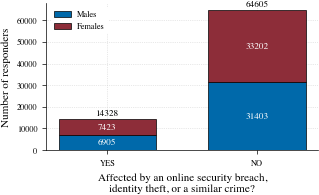

In [16]:
xpos = ['YES', 'NO']
male_yn = [count_sex.query('PESEX == 1 and HEPSCYBA == 1')['count'].iloc[0],
           count_sex.query('PESEX == 1 and HEPSCYBA == 2')['count'].iloc[0]
          ]
female_yn = [count_sex.query('PESEX == 2 and HEPSCYBA == 1')['count'].iloc[0],
           count_sex.query('PESEX == 2 and HEPSCYBA == 2')['count'].iloc[0]
          ]

with plt.rc_context({**bundles.icml2022(column='half', nrows=1, ncols=1, usetex=False),
                     **tueplots.axes.lines()
                    }):
    
    fig, ax = plt.subplots()
    b = ax.bar(xpos, male_yn, color=rgb.tue_blue, ec="black", width=0.65, label="Males")
    ax.bar_label(b, padding=0, color = 'w', fontsize='small', label_type="center")
    
    b = ax.bar(xpos, female_yn, bottom=male_yn, color=rgb.tue_red, ec="black", width=0.65, label= "Females")
    ax.bar_label(b, padding=0, color = 'w', fontsize = 'small', label_type="center")
    
    total = np.array(male_yn) + np.array(female_yn)
    for i, p in enumerate(total):
        ax.text(xpos[i], total[i]+1500, f"{total[i]}", ha='center', fontsize='small')
    
    
    ax.grid(True, color = "lightgrey", ls = ":")
    ax.set_xlabel("Affected by an online security breach,\nidentity theft, or a similar crime?")
    ax.legend(loc = 'upper left', framealpha=1.0, facecolor='white', edgecolor='none')
    ax.set_ylabel("Number of responders")
    
    # Add spines
    ax.spines["top"].set(visible = False)
    ax.spines["right"].set(visible = False)
        
    #plt.savefig("../res/figures/hepscyba_gender_distribution.pdf")
    plt.show()

**Conclusion:** From the above plot, it looks like there is an uniform distribution of males and females in the population.

## Distribution of concerns and online activities among population:
We have seen earlier that in our dataset, we have questions on different concerns (`HEPSCON*` variables) and
yes/no responses from people if they feel that variable represents their most important concern when it comes
to online privacy and security risks. In our subsequent analyses we will use these as one of the response 
variables, and here we find how many people responded YES ("1") to it to obtain the sample size for each 
category.

Similarly we have another set of response variables (`HEPSPRE{1-5}`) that asks people if they hesitated to 
some activity (specified by the variable, e.g., `HEPSPRE1` asks it for `Conducting financial transactions such 
as banking, investing, or paying bills online`) online because of privacy/safety concerns. We will also plot 
their sample sizes (i.e., the number of people whose response was affirmative to the question).

In [19]:
sort_dict = lambda x: dict(sorted(x.items(), key=lambda item: -item[1]))

concerns_size = sort_dict({concern: df21.query(f'{concern} == 1').shape[0] for concern in CONCERNS})
activities_size = sort_dict({activity: df21.query(f'{activity} == 1').shape[0] for activity in ACTIVITIES})

In [25]:
activity = ACTIVITIES[0]
# df21.query(f'{activity} == -1')

In [21]:
# number of people who said they feel this concern
concerns_size

{'HEPSCON1': 40329,
 'HEPSCON2': 33499,
 'HEPSCON3': 20904,
 'HEPSCON5': 18229,
 'HEPSCON4': 14923,
 'HEPSCON6': 10273,
 'HEPSCON8': 2698}

In [22]:
# number of people who said they hesitate to do the activity on the internet
activities_size

{'HEPSPRE1': 14320,
 'HEPSPRE3': 10938,
 'HEPSPRE2': 10699,
 'HEPSPRE4': 10546,
 'HEPSPRE5': 6966}

## Prepare a bar-plot with counts for each kind of concern

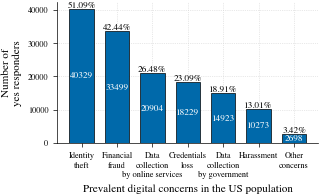

In [23]:
# xpos = np.arange(len(activities_size))
xpos = concerns_size.keys()
xpos = [CONCERNS_LABELS_FOR_PLOTS[item] for item in xpos]
counts_concern = list(concerns_size.values())

with plt.rc_context({**bundles.icml2022(column='half', nrows=1, ncols=1, usetex=False), **tueplots.axes.lines()}):
    fig, ax = plt.subplots()
    b = ax.bar(xpos, counts_concern, color=rgb.tue_blue, ec="black", width=0.69)#, label="Responded Yes")
    ax.bar_label(b, padding=0, color = 'w', fontsize='small', label_type="center")
    
    pcts = np.array(counts_concern) / (df21.shape[0] - df21.query(f'{CONCERNS[0]} == -1').shape[0])
    for i, p in enumerate(pcts):
        ax.text(xpos[i], counts_concern[i]+500, f"{p*100:.2f}%", ha='center', fontsize='small')
    
    ax.grid(True, color = "lightgrey", ls = ":")
    ax.set_xlabel("Prevalent digital concerns in the US population")
    # ax.legend(loc = 'upper right', framealpha=1.0, facecolor='white', edgecolor='none')
    ax.set_ylabel("Number of\nyes responders")
    
    # Add spines
    ax.spines["top"].set(visible = False)
    ax.spines["right"].set(visible = False)
    
    
    plt.savefig(f"../res/figures/concern_distribution_{year}.pdf")
    plt.show()

## Plot the same chart for online activities that people hesitated to do
We highlight one response variable in orange as we will try to understand the factors behind it by stratifying
it across different categories in the dataset.

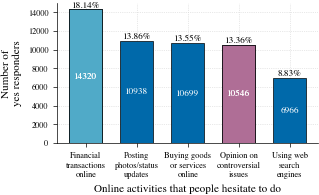

In [27]:
# xpos = np.arange(len(activities_size))
xpos = activities_size.keys()
xpos = [ACTIVITY_LABELS_FOR_PLOTS[item] for item in xpos]
counts_concern = list(activities_size.values())

with plt.rc_context({**bundles.icml2022(column='half', nrows=1, ncols=1, usetex=False), **tueplots.axes.lines()}):
    fig, ax = plt.subplots()
    b = ax.bar(xpos, counts_concern, color=rgb.tue_blue, ec="black", width=0.65)#, label="Responded Yes")
    ax.bar_label(b, padding=0, color = 'w', fontsize='small', label_type="center")
    
    b1 = ax.bar([xpos[3]], [counts_concern[3]], color=rgb.tue_violet, ec='black', width=0.65)
    ax.bar_label(b1, padding=0, color='w', fontsize='small', label_type="center")
    
    b1 = ax.bar([xpos[0]], [counts_concern[0]], color=rgb.tue_lightblue, ec='black', width=0.65)
    ax.bar_label(b1, padding=0, color='w', fontsize='small', label_type="center")
    
    pcts = np.array(counts_concern) / (df21.shape[0] - df21.query(f'{activity} == -1').shape[0])
    for i, p in enumerate(pcts):
        ax.text(xpos[i], counts_concern[i]+250, f"{p*100:.2f}%", ha='center', fontsize='small')
    
    ax.grid(True, color = "lightgrey", ls = ":")
    ax.set_xlabel("Online activities that people hesitate to do")
    # ax.legend(loc = 'upper right', framealpha=1.0, facecolor='white', edgecolor='none')
    ax.set_ylabel("Number of\nyes responders")
    
    # Add spines
    ax.spines["top"].set(visible = False)
    ax.spines["right"].set(visible = False)
    
    plt.savefig(f"../res/figures/activity_distribution_{year}.pdf")

    plt.show()

## Prepare some other maps

In [28]:
columnsmapa= {
    'HEPSPRE1': 'Financial transactions',
    'HEPSPRE2': 'Online shopping',
    'HEPSPRE3': 'Posting photos, status updates',
    'HEPSPRE4': 'Expressing controversial opinions',
    'HEPSPRE5': 'Searching on google, yahoo, bing'
}

columnsmapc = {
    'HEPSCON1': 'Identity theft',
    'HEPSCON2': 'Credit card fraus',
    'HEPSCON3': 'Data tracking',
    'HEPSCON4': 'Govt. data collection',
    'HEPSCON5': 'Losing digital credentials',
    'HEPSCON6': 'Cyber harrassment',
    'HEPSCON8': 'Other'
}

# poverty guidelines: https://aspe.hhs.gov/2021-poverty-guidelines
income_groups = {
    "below 35k": [1,2,3,4,5,6,7,8,9],
    "35k-60k": [10,11,12], #13],
    "60k-100k": [13, 14],
    "100k-150k": [15],
    "above 150k": [16]
}

age_groups = {
    '10-18':    [10, 18],
    '18-25':    [18, 25],
    '26-35':    [26, 35],
    '36-45':    [36, 45],
    '46-55':    [46, 55],
    '56-65':    [56, 65],
    '66+':      [66, 120],
}

education_groups = maps.educ  # education_educationid_mapping
industry_groups = maps.ind    # industry_jobid_mapping

In [29]:
education_groups, industry_groups

({'LTHS': [31, 32, 33, 34, 35, 36, 37, 38],
  'HS': [39],
  'SC': [40, 41, 42],
  'COLL': [43],
  'ADV': [44, 45, 46]},
 {'Construction and mining': [1, 2, 3],
  'Finance and business services': [7, 8, 9, 12],
  'Manufacturing': [4],
  'Trade, transportation, and utilities': [5, 6],
  'Education and health': [10],
  'Leisure and hospitality': [11],
  'Public administration': [13],
  'Armed forces': [14]})

## stratify and see proportions

In [30]:
def stratified_proportions(df,
                           stratify_by,      # age, income, education or job industry
                           categories_dict,  # mapping of age groups etc. as shown above
                           target_variables, # list of concerns/activities
                          ):
    
    # for each group, stores the probability of responding "YES" for each target variable
    stratified_output_count_normalized = {}
    sample_sizes = {}
    
    
    v = stratify_by
    for groupname, groupids in categories_dict.items():
        if v != 'PRTAGE':
            query_string = ' or '.join([f'{v} == {gid}' for gid in groupids])
        else:
            query_string = f'{v} >= {groupids[0]} and {v} <= {groupids[1]}'
        # print(groupname)
        _df = df.query(query_string)[target_variables]
        
        props = []  # props[i] = proportion for target variable i
        sample_size = []
        for tv in target_variables:
            # Take 1 target variable and find the proportion of people who responded as 1 (yes)
            _df1 = _df[[tv]]
            _df1 = _df1[_df1[tv] != -1]  # remove the -1 responses (only keep 1 or 2)
#             print(f'total #samples in this group for {tv} (Yes/No) = {_df1.shape[0]}')
#             print(f'yes: {_df1.value_counts()[1]}, no: {_df1.value_counts()[2]}; proportion: {_df1.value_counts(normalize=True)[1]:.4f}')
            props.append(_df1.value_counts(normalize=True)[1])
            sample_size.append(_df1.shape[0])
        
        stratified_output_count_normalized[groupname] = props
        sample_sizes[groupname] = sample_size
        
    return stratified_output_count_normalized, sample_sizes

In [31]:
# # call
# res, sample_sizes = stratified_proportions(df21, stratify_by='HEFAMINC',
#                              categories_dict=income_groups,
#                              target_variables=ACTIVITIES)

# df = pd.DataFrame.from_dict(res, orient='index')
# # df = df[[3]]
# df = df.rename(columns= {
#     0: 'financial transactions',
#     1: 'online shopping',
#     2: 'posting photos, status updates',
#     3: 'expressing controversial opinions',
#     4: 'searching on google, yahoo, bing'
# })



# # Plot the DataFrame
# ax = df.plot(kind='bar')
# ax.set_title("What people hesitate to do stratified by annual income levels", color='black')
# ax.legend(bbox_to_anchor=(1.0, 1.0))
# ax.plot()

# # Show the plot
# plt.show()

In [32]:
# res

In [33]:
# sample_sizes

## Prepare a plot to show how the responses vary across different income groups

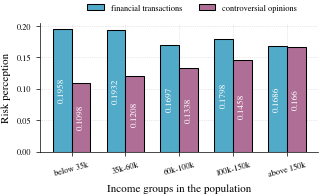

In [35]:
# call
res, sample_sizes = stratified_proportions(df21, stratify_by='HEFAMINC',
                             categories_dict=income_groups,
                             target_variables=ACTIVITIES)

xpos = list(res.keys())
X = np.arange(len(xpos))

fins = np.array([res[key][0] for key in xpos])
fins = np.around(fins,4)
fins_no = [round(res[key][0]*sample_sizes[key][0]) for key in xpos]

opin = np.array([res[key][3] for key in xpos])
opin = np.around(opin,4)

opin_no = [round(res[key][3]*sample_sizes[key][3]) for key in xpos]

# X, xpos, opin


with plt.rc_context({**bundles.icml2022(column='half', nrows=1, ncols=1, usetex=False), **tueplots.axes.lines()}):
    fig, ax = plt.subplots()
    
    # Add spines
    ax.spines["top"].set(visible = False)
    ax.spines["right"].set(visible = False)
    
    # Add grid and axis labels
    ax.grid(True, color = "lightgrey", ls = ":")
    
    # We specify the width of the bar
    width = 0.35
    
    b = ax.bar(
        X, 
        fins, 
        ec = "black", 
        lw = .75,
        color = rgb.tue_lightblue, 
        zorder = 3, 
        width = width,
        label = "financial transactions"
    )
    ax.bar_label(b, padding=0, color = 'w', fontsize='small', label_type="center", rotation=90)

    b = ax.bar(
        X + width, 
        opin, 
        ec = "black", 
        lw = .75, 
        color = rgb.tue_violet, 
        zorder = 3, 
        width = width,
        label = "controversial opinions"
    )
    ax.bar_label(b, padding=0, color = 'w', fontsize='small', label_type="center", rotation=90)
    
    
    # Adjust ticks
    xticks_ = ax.xaxis.set_ticks(
        ticks = X + width/2,
        labels = xpos,
        rotation = 15
    )
    
    ax.set_xlabel("Income groups in the population")
    ax.legend(loc = 'upper right', framealpha=1.0, facecolor='white', edgecolor='none')
    ax.legend(
        ncol = 2, 
        loc = "upper right", 
        framealpha=1.0, facecolor='white', edgecolor='none',
        
        bbox_to_anchor = (0.95, 1.2),
        # frameon = False
    )
    ax.set_ylabel("Risk perception")
    
    plt.savefig(f"../res/figures/income_bar_{year}.pdf")
    plt.show()

In [36]:
df

,financial transactions,online shopping,"posting photos, status updates",expressing controversial opinions,"searching on google, yahoo, bing"
below 35k,0.195754,0.151253,0.120127,0.109752,0.081204
35k-60k,0.193156,0.138111,0.128936,0.120754,0.086474
60k-100k,0.169695,0.127157,0.136954,0.133807,0.087766
100k-150k,0.179761,0.131181,0.147401,0.145818,0.092017
above 150k,0.168625,0.129533,0.166377,0.166014,0.096098


## Do same for education levels

In [55]:
# # call
# v = 'PEEDUCA'
# res, sample_sizes = stratified_proportions(df21, stratify_by=v,
#                              categories_dict=education_groups,
#                              target_variables=ACTIVITIES)

# df = pd.DataFrame.from_dict(res, orient='index')
# # df = df[[3]]
# df = df.rename(columns= {
#     0: 'financial transactions',
#     1: 'online shopping',
#     2: 'posting photos, status updates',
#     3: 'expressing controversial opinions',
#     4: 'searching on google, yahoo, bing'
# })



# # Plot the DataFrame
# ax = df.plot(kind='bar')
# ax.set_title("What people hesitate to do stratified by education groups", color='black')
# ax.legend(bbox_to_anchor=(1.0, 1.0))
# ax.plot()

# # Show the plot
# plt.show()

In [56]:
# sample_sizes

## Variations wrt education groups

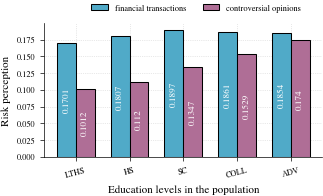

In [36]:
# call
v = 'PEEDUCA'
res, sample_sizes = stratified_proportions(df21, stratify_by=v,
                             categories_dict=education_groups,
                             target_variables=ACTIVITIES)

xpos = list(res.keys())
X = np.arange(len(xpos))

fins = np.array([res[key][0] for key in xpos])
fins = np.around(fins,4)
fins_no = [round(res[key][0]*sample_sizes[key][0]) for key in xpos]

opin = np.array([res[key][3] for key in xpos])
opin = np.around(opin,4)

opin_no = [round(res[key][3]*sample_sizes[key][3]) for key in xpos]

# X, xpos, opin

with plt.rc_context({**bundles.icml2022(column='half', nrows=1, ncols=1, usetex=False), **tueplots.axes.lines()}):
    fig, ax = plt.subplots()
    
    # Add spines
    ax.spines["top"].set(visible = False)
    ax.spines["right"].set(visible = False)
    
    # Add grid and axis labels
    ax.grid(True, color = "lightgrey", ls = ":")
    
    # We specify the width of the bar
    width = 0.35
    
    # Fouls conceded
    b = ax.bar(
        X, 
        fins, 
        ec = "black", 
        lw = .75,
        color = rgb.tue_lightblue, 
        zorder = 3, 
        width = width,
        label = "financial transactions"
    )
    ax.bar_label(b, padding=0, color = 'w', fontsize='small', label_type="center", rotation=90)

    b = ax.bar(
        X + width, 
        opin, 
        ec = "black", 
        lw = .75, 
        color = rgb.tue_violet, 
        zorder = 3, 
        width = width,
        label = "controversial opinions"
    )
    ax.bar_label(b, padding=0, color = 'w', fontsize='small', label_type="center", rotation=90)
    
    
    # Adjust ticks
    xticks_ = ax.xaxis.set_ticks(
        ticks = X + width/2,
        labels = xpos,
        rotation = 15
    )
    
    ax.set_xlabel("Education levels in the population")
    ax.legend(loc = 'upper right', framealpha=1.0, facecolor='white', edgecolor='none')
    ax.legend(
        ncol = 2, 
        loc = "upper right", 
        framealpha=1.0, facecolor='white', edgecolor='none',
        
        bbox_to_anchor = (0.95, 1.2),
        # frameon = False
    )
#     ax.set_ylabel("Probability of responding yes\ngiven a person belongs\nto a certain group")
    ax.set_ylabel("Risk perception")
#     plt.savefig(f"../res/figures/{v}_bar_{year}.pdf")
    plt.show()

In [43]:
# df

In [52]:
# # call
# v = 'PRTAGE'
# categories = age_groups
# res, sample_sizes = stratified_proportions(df21, stratify_by=v,
#                              categories_dict=categories,
#                              target_variables=ACTIVITIES)

# # df = pd.DataFrame.from_dict(res, orient='index')
# # # df = df[[3]]
# # df = df.rename(columns= {
# #     0: 'financial transactions',
# #     1: 'online shopping',
# #     2: 'posting photos, status updates',
# #     3: 'expressing controversial opinions',
# #     4: 'searching on google, yahoo, bing'
# # })



# # # Plot the DataFrame
# # ax = df.plot(kind='bar')
# # ax.set_title("What people hesitate to do stratified by age groups", color='black')
# # ax.legend(bbox_to_anchor=(1.0, 1.0))
# # ax.plot()

# # # Show the plot
# # plt.show()

## Variations wrt age

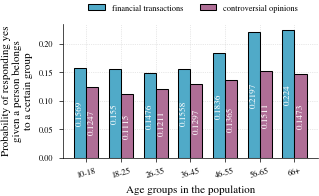

In [51]:
v = 'PRTAGE'
categories = age_groups
res, sample_sizes = stratified_proportions(df21, stratify_by=v,
                             categories_dict=categories,
                             target_variables=ACTIVITIES)

xpos = list(res.keys())
X = np.arange(len(xpos))

fins = np.array([res[key][0] for key in xpos])
fins = np.around(fins,4)
fins_no = [round(res[key][0]*sample_sizes[key][0]) for key in xpos]

opin = np.array([res[key][3] for key in xpos])
opin = np.around(opin,4)

opin_no = [round(res[key][3]*sample_sizes[key][3]) for key in xpos]

with plt.rc_context({**bundles.icml2022(column='half', nrows=1, ncols=1, usetex=False), **tueplots.axes.lines()}):
    fig, ax = plt.subplots()
    
    # Add spines
    ax.spines["top"].set(visible = False)
    ax.spines["right"].set(visible = False)
    
    # Add grid and axis labels
    ax.grid(True, color = "lightgrey", ls = ":")
    
    # We specify the width of the bar
    width = 0.35
    
    # Fouls conceded
    b = ax.bar(
        X, 
        fins, 
        ec = "black", 
        lw = .75,
        color = rgb.tue_lightblue, 
        zorder = 3, 
        width = width,
        label = "financial transactions"
    )
    ax.bar_label(b, padding=0, color = 'w', fontsize='small', label_type="center", rotation=90)

    b = ax.bar(
        X + width, 
        opin, 
        ec = "black", 
        lw = .75, 
        color = rgb.tue_violet, 
        zorder = 3, 
        width = width,
        label = "controversial opinions"
    )
    ax.bar_label(b, padding=0, color = 'w', fontsize='small', label_type="center", rotation=90)
    
    
    # Adjust ticks
    xticks_ = ax.xaxis.set_ticks(
        ticks = X + width/2,
        labels = xpos,
        rotation = 15
    )
    
    ax.set_xlabel("Age groups in the population")
    ax.legend(loc = 'upper right', framealpha=1.0, facecolor='white', edgecolor='none')
    ax.legend(
        ncol = 2, 
        loc = "upper right", 
        framealpha=1.0, facecolor='white', edgecolor='none',
        
        bbox_to_anchor = (0.95, 1.2),
        # frameon = False
    )
    ax.set_ylabel("Probability of responding yes\ngiven a person belongs\nto a certain group")
    
    # plt.savefig(f"../res/figures/{v}_bar_{year}.pdf")
    plt.show()

## Chi-square test

We have seen that we have a **binary** response variable `HEPSPRE4`, which asks people if they feel safe while
expressing _controversial_ opinions on the internet. And above, we observed that when the population is
split into 5 categories according to their annual family income levels (groups determined by consulting 2021
[US poverty guidelines](https://aspe.hhs.gov/2021-poverty-guidelines)), the fraction of the people who respond
"YES" to that question (`HEPSPRE4`) seems to show an increasing trend with income. Here, we want to test if
there is a suggestion/evidence of an association between the two variables: the binary response variable
`HEPSPRE4` and the categorical income level variable.

Since both variables are categorical, we consider doing a _chi-square test_ to test the null hypothesis that
there is no overall difference between people from different income levels with respect to how safe they feel
while expressing something controversial on the internet. To perform the test, we first construct the
5 x 2 contingency table (5 income groups, 2 response outcomes) for the two variables, and compute the expected
counts under the null hypothesis, that is simply the `(row total * column total) / total sample size` for a
(row, column) position in the contingency table.

Once we obtain the two tables (observed and expected counts), we compute the chi-square statistic and
obtain the p-value to test the significance.


References:
---
[1] [Chi-Square Test for Independence](https://online.stat.psu.edu/stat500/book/export/html/477)

[2] [Chi-square test for multiple categories](https://web.pdx.edu/~newsomj/pa551/lectur11.htm)

[3] [Concepts & Applications of Inferential Statistics, Chi-Square Procedures for Two Dimensions of Categorization](http://vassarstats.net/textbook/index.html)

In [31]:
v = 'HEFAMINC'
categories_dict = income_groups
opinion_variable = 'HEPSPRE4'  # expressing controversial opinions
financial_variable = 'HEPSPRE1'  # expressing controversial opinions

target_variable = opinion_variable

arr = []
for groupname, groupids in categories_dict.items():
    query_string = ' or '.join([f'{v} == {gid}' for gid in groupids])
    print(groupname, query_string)
    
    _df = df21.query(query_string)[[target_variable]]
    _df = _df[_df[target_variable] != -1]  # remove the -1 responses (only keep 1 or 2)
    print(_df.shape)
    print(f'proportion: {_df.value_counts(normalize=True)[1]:.4f}')
    print(f'yes: {_df.value_counts()[1]}, no: {_df.value_counts()[2]}')
    arr.append([_df.value_counts()[1], _df.value_counts()[2], len(_df)])
    print('----')

below 35k HEFAMINC == 1 or HEFAMINC == 2 or HEFAMINC == 3 or HEFAMINC == 4 or HEFAMINC == 5 or HEFAMINC == 6 or HEFAMINC == 7 or HEFAMINC == 8 or HEFAMINC == 9
(16674, 1)
proportion: 0.1098
yes: 1830, no: 14844
----
35k-60k HEFAMINC == 10 or HEFAMINC == 11 or HEFAMINC == 12
(16132, 1)
proportion: 0.1208
yes: 1948, no: 14184
----
60k-100k HEFAMINC == 13 or HEFAMINC == 14
(19700, 1)
proportion: 0.1338
yes: 2636, no: 17064
----
100k-150k HEFAMINC == 15
(12639, 1)
proportion: 0.1458
yes: 1843, no: 10796
----
above 150k HEFAMINC == 16
(13788, 1)
proportion: 0.1660
yes: 2289, no: 11499
----


In [32]:
1830+1948+2636+1843+2289

10546

In [33]:
arr = np.array(arr)
do = pd.DataFrame(arr, columns=['Yes', 'No', 'Total (rows)'])
do.index = categories_dict.keys()
do.loc['Total (cols)'] = do.sum(0)
do

,Yes,No,Total (rows)
below 35k,1830,14844,16674
35k-60k,1948,14184,16132
60k-100k,2636,17064,19700
100k-150k,1843,10796,12639
above 150k,2289,11499,13788
Total (cols),10546,68387,78933


In [34]:
observed_table = do.iloc[0:len(categories_dict), :2]
observed_table

,Yes,No
below 35k,1830,14844
35k-60k,1948,14184
60k-100k,2636,17064
100k-150k,1843,10796
above 150k,2289,11499


In [41]:
print(do.to_latex(multicolumn=True, multirow=True))

\begin{tabular}{lrrr}
\toprule
 & Yes & No & Total (rows) \\
\midrule
below 35k & 1830 & 14844 & 16674 \\
35k-60k & 1948 & 14184 & 16132 \\
60k-100k & 2636 & 17064 & 19700 \\
100k-150k & 1843 & 10796 & 12639 \\
above 150k & 2289 & 11499 & 13788 \\
Total (cols) & 10546 & 68387 & 78933 \\
\bottomrule
\end{tabular}



In [38]:
# ind = pd.MultiIndex.from_product([
#     ['income levels'],
#     list(income_groups.keys())
# ])

col = pd.MultiIndex.from_product([
    ['hesitate to express opinions?'],
    ['Yes', 'No']
])

tab = pd.DataFrame(observed_table.values, index=ind, columns=col)
tab

hesitate to express opinions?       
                                                   Yes     No
income levels below 35k                           1830  14844
              35k-60k                             1948  14184
              60k-100k                            2636  17064
              100k-150k                           1843  10796
              above 150k                          2289  11499

In [39]:
print(tab.to_latex(multicolumn=True, multirow=True))

\begin{tabular}{llrr}
\toprule
 &  & \multicolumn{2}{r}{hesitate to express opinions?} \\
 &  & Yes & No \\
\midrule
\multirow[t]{5}{*}{income levels} & below 35k & 1830 & 14844 \\
 & 35k-60k & 1948 & 14184 \\
 & 60k-100k & 2636 & 17064 \\
 & 100k-150k & 1843 & 10796 \\
 & above 150k & 2289 & 11499 \\
\cline{1-4}
\bottomrule
\end{tabular}



In [35]:
# expected counts under null hypothesis
# https://online.stat.psu.edu/stat500/book/export/html/477
expected_table = (observed_table.sum(1).values[:, None] * observed_table.sum(0).values[None, :]) / observed_table.values.sum()
expected_table

array([[ 2227.76283684, 14446.23716316],
       [ 2155.34785198, 13976.65214802],
       [ 2632.05756781, 17067.94243219],
       [ 1688.65865988, 10950.34134012],
       [ 1842.1730835 , 11945.8269165 ]])

In [37]:
expected_df = pd.DataFrame(np.around(expected_table,2), columns=observed_table.columns,
                          index=observed_table.index)
expected_df

,Yes,No
below 35k,2227.76,14446.24
35k-60k,2155.35,13976.65
60k-100k,2632.06,17067.94
100k-150k,1688.66,10950.34
above 150k,1842.17,11945.83


In [44]:
combined_table = np.zeros((observed_table.shape[0], 2*observed_table.shape[1]))
combined_table[:,0] = observed_table.values[:, 0]
combined_table[:,1] = expected_df.values[:, 0]
combined_table[:,2] = observed_table.values[:, 1]
combined_table[:,3] = expected_df.values[:, 1]

combined_table

array([[ 1830.  ,  2227.76, 14844.  , 14446.24],
       [ 1948.  ,  2155.35, 14184.  , 13976.65],
       [ 2636.  ,  2632.06, 17064.  , 17067.94],
       [ 1843.  ,  1688.66, 10796.  , 10950.34],
       [ 2289.  ,  1842.17, 11499.  , 11945.83]])

In [45]:
r, c = observed_table.shape
dof = (r-1)*(c-1)

# compute test statistic manually
chi2 = ((observed_table.values.flatten() - expected_table.flatten())**2 / (expected_table.flatten())).sum()
chi2

246.37695704437385

In [47]:
dof

4

In [46]:
from scipy.stats import chisquare
chisquare(f_obs=observed_table.values.flatten(), f_exp=expected_table.flatten(), ddof=dof)

Power_divergenceResult(statistic=246.37695704437385, pvalue=3.2916968758376956e-51)

In [204]:
def perform_chi_square_test(df,
                            explanatory_variable,
                            response_variable,
                            categories_dict
                           ):
    
    from scipy.stats import chisquare
    
    target_variable = response_variable  # binary, values: 1 or 2

    arr = []
    for groupname, groupids in categories_dict.items():
        query_string = ' or '.join([f'{v} == {gid}' for gid in groupids])
        print(groupname, query_string)

        _df = df.query(query_string)[[target_variable]]
        _df = _df[_df[target_variable] != -1]  # remove the -1 responses (only keep 1 or 2)
        print(_df.shape)
        print(f'proportion: {_df.value_counts(normalize=True)[1]:.4f}')
        print(f'yes: {_df.value_counts()[1]}, no: {_df.value_counts()[2]}')
        arr.append([_df.value_counts()[1], _df.value_counts()[2]])
        print('----')
        
    observed_table = np.array(arr)
    expected_table = (observed_table.sum(1)[:, None] * observed_table.sum(0)[None, :]) / observed_table.sum()
    
    r, c = observed_table.shape
    dof = (r-1)*(c-1)
    chi2 = ((observed_table.flatten() - expected_table.flatten())**2 / (expected_table.flatten())).sum()
    
    return chisquare(f_obs=observed_table.flatten(), f_exp=expected_table.flatten(), ddof=dof)

In [205]:
perform_chi_square_test(df21, v, opinion_variable, income_groups)

below 35k HEFAMINC == 1 or HEFAMINC == 2 or HEFAMINC == 3 or HEFAMINC == 4 or HEFAMINC == 5 or HEFAMINC == 6 or HEFAMINC == 7 or HEFAMINC == 8 or HEFAMINC == 9
(16674, 1)
proportion: 0.1098
yes: 1830, no: 14844
----
35k-60k HEFAMINC == 10 or HEFAMINC == 11 or HEFAMINC == 12
(16132, 1)
proportion: 0.1208
yes: 1948, no: 14184
----
60k-100k HEFAMINC == 13 or HEFAMINC == 14
(19700, 1)
proportion: 0.1338
yes: 2636, no: 17064
----
100k-150k HEFAMINC == 15
(12639, 1)
proportion: 0.1458
yes: 1843, no: 10796
----
above 150k HEFAMINC == 16
(13788, 1)
proportion: 0.1660
yes: 2289, no: 11499
----


Power_divergenceResult(statistic=246.37695704437385, pvalue=3.2916968758376956e-51)